# DSE200x: Final Project
# Steve Hall: December 2019
## Forecasting Interest Rates using Machine Learning Techniques

## Import Libraries and Data 

In [59]:
# libraries
import pandas as pd
import numpy as np 
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# load database of market prices into pandas
raw = pd.read_csv('./data/db_MarketPredictors.csv', sep=',')

In [3]:
print(raw.shape)
raw.head()

(7811, 197)


,Day,Date,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
0,2,12/9/2019,3138.53,999.76,2015.46,8372.490,179.27,954.5700,641.06,436.85,...,9.44,0.35,0.48,0.37,0.42,0.29,0.71,0.49,0.86,0.86
1,6,12/6/2019,3145.91,1002.13,2021.98,8397.367,179.48,953.2015,639.92,437.91,...,9.44,0.35,0.48,0.37,0.42,0.29,0.71,0.49,0.86,0.86
2,5,12/5/2019,3117.43,988.01,2003.00,8308.396,178.36,945.5638,637.57,429.34,...,9.78,0.36,0.51,0.37,0.42,0.30,0.71,0.49,0.86,0.86
3,4,12/4/2019,3112.76,985.29,1999.53,8296.529,177.67,947.6669,638.77,431.48,...,9.79,0.36,0.50,0.37,0.42,0.30,0.71,0.49,0.85,0.85
4,3,12/3/2019,3093.20,977.51,1983.92,8254.737,176.54,943.8462,634.57,424.81,...,9.99,0.37,0.51,0.37,0.42,0.30,0.70,0.49,0.85,0.85


I have downloaded 195 series of market price data. The futures data is adjusted for the roll, adjusting the ratio between the prompt and next contract 5 days prior to expiration.
<br>
<br>
*Data source: Bloomberg; daily from 1/1/1990 through 12/9/2019.* 

In [4]:
raw['Date'] =pd.to_datetime(raw.Date)
raw = raw.sort_values('Date')

In [5]:
# let's add year and month-year to the dataframe
raw['Year'] = pd.DatetimeIndex(raw['Date']).year
raw['Year_MM'] = pd.to_datetime(raw['Date']).dt.to_period('M')
dates = raw['Date']
raw.head()

,Day,Date,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,...,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index,Year,Year_MM
7810,2,1990-01-01,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7809,3,1990-01-02,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7808,4,1990-01-03,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7807,5,1990-01-04,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7806,6,1990-01-05,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01


In [6]:
# remove day and date from the dataframe
raw_prices = raw.iloc[:,2:-2]
raw_prices.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
7810,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,76.14,72.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7809,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,77.35,73.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7808,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,77.48,74.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7807,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,76.97,73.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7806,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,76.24,72.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration

In [7]:
# create a df of statistics of the market prices
stats_prices = raw_prices.describe().transpose()

In [8]:
# now let's calculate daily price returns for each series
raw_rets = raw_prices.pct_change()
# add back the unique months-years
raw_rets['Year_MM'] = raw['Year_MM'] 
raw_rets.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index,Year_MM
7810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7809,0.017799,NaN,NaN,0.017379,0.013815,0.029815,0.008503,0.004475,0.015892,0.014746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7808,-0.002586,NaN,NaN,-0.007136,-0.007900,-0.002399,-0.002227,-0.014017,0.001681,0.007470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7807,-0.008613,NaN,NaN,-0.006126,-0.026774,-0.003753,-0.013233,-0.011682,-0.006582,-0.006740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7806,-0.009756,NaN,NaN,-0.007009,-0.021886,-0.007347,-0.008240,-0.009924,-0.009484,-0.014658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01


In [9]:
# create a df of statistics of the market prices
stats_rets = raw_rets.describe().transpose()

In [10]:
# average daily returns by month
monthly_rets = raw_rets.groupby(['Year_MM']).sum()
monthly_rets.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
Year_MM,,,,,,,,,,,,,,,,,,,,,
1990-01,-0.069845,0.0,0.0,-0.100755,-0.135176,-0.067095,-0.099511,-0.036108,-0.110280,-0.066651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02,0.009007,0.0,0.0,0.029817,-0.004466,0.018933,-0.015465,0.018433,0.032155,-0.027902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03,0.024480,0.0,0.0,0.025821,0.049772,0.029731,0.056362,0.003447,-0.031671,0.033875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04,-0.026771,0.0,0.0,-0.034203,-0.036512,-0.037562,0.012241,-0.038407,-0.044783,0.003263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-05,0.088675,0.0,0.0,0.138619,0.083135,0.102705,0.098296,0.060451,0.115542,0.121566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# number of months
len(monthly_rets)

360

In [16]:
# instead of summing daily returns we could calculate rolling 21 day returns (roughly 21 days/ month)
# let's create a function
def rolling_pct_rets(df, periods):
    rets = (df.shift(periods=periods, fill_value=0)/ df) - 1
    rets = rets[:periods]
    return rets

In [17]:
lookback = 21
monthly_rets2 = rolling_pct_rets(raw_prices, -lookback)
monthly_rets2.shape

(7790, 195)

In [18]:
# append dates to monthly_rets
Day = raw['Date'][:-lookback]
monthly_rets2 = pd.concat((monthly_rets2, Day), axis=1)
monthly_rets2 = monthly_rets2.sort_values('Date')

In [19]:
monthly_rets2.tail(22)

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index,Date
42,0.052738,0.076441,0.060621,0.066602,0.052543,0.019564,-0.001792,0.056905,0.090386,0.065839,...,-0.162791,-0.196429,0.050000,0.022222,0.090909,-0.054795,-0.090909,-0.035294,-0.046512,2019-10-10
41,0.039303,0.053463,0.040640,0.050745,0.037620,0.005261,-0.002770,0.036469,0.073785,0.052994,...,-0.121951,-0.134615,0.024390,0.000000,0.058824,-0.067568,-0.090909,-0.046512,-0.068182,2019-10-11
40,0.042375,0.057178,0.042933,0.053741,0.042818,0.005099,0.003828,0.031599,0.072892,0.059464,...,-0.097561,-0.115385,0.000000,0.000000,0.029412,-0.081081,-0.109091,-0.058140,-0.079545,2019-10-14
39,0.032834,0.039583,0.032297,0.039905,0.030532,-0.008281,0.016502,0.022296,0.052728,0.042269,...,-0.095238,-0.094340,-0.046512,-0.041667,-0.055556,-0.081081,-0.125000,-0.058140,-0.079545,2019-10-15
38,0.035770,0.034739,0.035924,0.042628,0.032126,-0.008856,0.014294,0.034744,0.056256,0.042736,...,-0.136364,-0.092593,-0.046512,-0.041667,-0.081081,-0.068493,-0.127273,-0.035294,-0.058140,2019-10-16
37,0.040865,0.028574,0.031960,0.047012,0.032853,-0.010561,0.011233,0.041280,0.059845,0.057773,...,-0.181818,-0.145455,-0.069767,-0.062500,-0.108108,-0.068493,-0.127273,-0.035294,-0.034884,2019-10-17
36,0.045486,0.029767,0.031573,0.058459,0.044815,-0.004027,0.014757,0.033043,0.058956,0.057346,...,-0.159091,-0.142857,-0.093023,-0.063830,-0.111111,-0.082192,-0.145455,-0.047059,-0.057471,2019-10-18
35,0.037735,0.022277,0.027566,0.050175,0.037794,-0.018294,0.008937,-0.000747,0.045742,0.065043,...,-0.136364,-0.089286,-0.095238,-0.065217,-0.138889,-0.069444,-0.129630,-0.035714,-0.046512,2019-10-21
34,0.037540,0.013127,0.024185,0.051956,0.038904,-0.013974,0.010501,-0.003432,0.043454,0.062296,...,-0.088889,-0.101695,-0.097561,-0.066667,-0.142857,-0.069444,-0.129630,-0.035714,-0.046512,2019-10-22
33,0.032957,0.005852,0.016283,0.047677,0.034909,-0.014894,0.000382,0.005305,0.038716,0.057999,...,-0.136364,-0.137931,-0.121951,-0.088889,-0.171429,-0.056338,-0.132075,-0.047619,-0.047059,2019-10-23


In [20]:
# Now let's compare both approaches to calculating average monthly returns
stats_Mrets = monthly_rets.describe().transpose()
stats_Mrets2 = monthly_rets2.describe().transpose()

In [21]:
ave_ret_comp = pd.concat([stats_Mrets['mean']*12, stats_Mrets2['mean']*12], axis=1) #multiply by 12 to annualize
ave_ret_comp.columns.values[0] = "Calendar"
ave_ret_comp.columns.values[1] = "Rolling"
ave_ret_comp['Diff'] = ave_ret_comp['Calendar'] - ave_ret_comp['Rolling']
ave_ret_comp.head(15)

,Calendar,Rolling,Diff
S&P 500,0.087993,0.082718,0.005276
S&P 600,0.095317,0.103553,-0.008236
S&P 400,0.117439,0.116063,0.001376
Nasdaq 100,0.156072,0.146620,0.009452
Comm. Services,0.040912,0.037339,0.003573
Cons. Disc,0.106444,0.101716,0.004728
Cons. Staples,0.088546,0.085452,0.003094
Energy,0.079166,0.069815,0.009351
Financials,0.098950,0.087595,0.011354
Health Care,0.108922,0.102695,0.006227


You can see the average annualized monthly returns are fairly similar across indices and sectors.

## Data Preprocessing

Let's start by selecting monthly changes in interest rates. We will use the 10-year Treasury yield as our proxy. 

In [25]:
# Our label or response variable
TenYr = monthly_rets2['USGG10YR Index']
TenYr.head(22)

7810    0.071330
7809    0.061538
7808    0.055054
7807    0.065479
7806    0.067009
7805    0.070894
7804    0.065801
7803    0.051784
7802    0.030582
7801    0.035697
7800    0.025515
7799    0.021596
7798    0.027103
7797    0.013248
7796    0.029883
7795    0.043410
7794    0.030423
7793    0.020679
7792    0.014739
7791   -0.000591
7790   -0.014177
7789    0.001647
Name: USGG10YR Index, dtype: float64

In [26]:
# Now we need to shift it forward 21 days since we want to predict forward changes in rates
Fwd_TenYr = TenYr.shift(periods=-21)
print(len(Fwd_TenYr))
Fwd_TenYr.head()
# note that the 22nd observation is now the first obervation (0.001647)

7790


7810    0.001647
7809    0.019363
7808    0.015809
7807    0.016129
7806    0.005048
Name: USGG10YR Index, dtype: float64

In [27]:
# Let's select a sample of the data that we want to use for model development
# I'm going to use the last 5000 days (~20 years of data)
n = 5000
select_Y = Fwd_TenYr.iloc[-n:]
print(select_Y.shape)
select_Y.tail()

(5000,)


25   NaN
24   NaN
23   NaN
22   NaN
21   NaN
Name: USGG10YR Index, dtype: float64

In [30]:
# select returns for market predictors except spreads
returns_ex_spreads = monthly_rets2.iloc[:,:100]
returns_ex_spreads.shape

(7790, 100)

In [31]:
spreads = raw_prices.iloc[:-lookback,-25:]
spreads.shape

(7790, 25)

In [38]:
features = pd.concat((returns_ex_spreads, spreads), axis=1)
features = features[-n:]
print(features.shape)
features.head()

(5000, 125)


,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
5020,-0.068652,-0.082180,-0.076917,-0.139867,-0.027295,-0.076512,0.067455,0.020499,-0.087815,0.079171,...,12.16,0.96,1.07,1.10,0.76,0.89,1.29,NaN,1.29,NaN
5019,-0.079218,-0.088097,-0.085106,-0.154448,-0.063758,-0.102969,0.058530,0.026786,-0.094654,0.075919,...,12.12,0.94,1.05,1.09,0.75,0.88,1.29,NaN,1.29,NaN
5018,-0.104471,-0.105718,-0.101957,-0.197047,-0.093268,-0.157737,0.055961,0.054114,-0.133303,0.066796,...,12.17,0.91,1.03,1.09,0.75,0.89,1.29,NaN,1.29,NaN
5017,-0.072052,-0.083330,-0.080931,-0.122986,-0.055838,-0.129963,0.070335,0.022787,-0.089256,0.059246,...,12.12,0.92,1.02,1.09,0.76,0.89,1.29,NaN,1.29,NaN
5016,-0.062211,-0.076171,-0.070458,-0.116113,-0.057462,-0.114251,0.088936,-0.027240,-0.064072,0.080528,...,12.15,0.86,0.99,1.09,0.76,0.89,1.21,NaN,1.21,NaN


In [39]:
select_X = features.dropna(axis='columns')
print(select_X.shape)
select_X.tail()

(5000, 117)


,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCBAOAS Index,BCBHOAS Index,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BNA1OAS Index
25,0.004850,-0.011428,-0.005604,0.005368,0.014889,-0.014012,0.021145,-0.058322,0.004414,0.043553,...,1.85,3.71,9.24,0.37,0.50,0.42,0.47,0.36,0.71,0.84
24,0.012405,-0.004938,0.000100,0.010518,0.022091,-0.011442,0.025346,-0.047863,0.010059,0.062583,...,1.97,3.77,9.38,0.39,0.51,0.42,0.46,0.36,0.70,0.83
23,0.013212,0.003524,0.006356,0.013710,0.028130,-0.014207,0.018076,-0.030376,0.009672,0.056987,...,2.02,3.83,9.32,0.39,0.51,0.41,0.46,0.35,0.71,0.83
22,0.019684,0.014795,0.014724,0.021621,0.027714,-0.000607,0.025759,-0.026391,0.016525,0.061981,...,1.93,3.71,8.99,0.37,0.48,0.41,0.46,0.35,0.70,0.83
21,0.014694,0.011330,0.008542,0.014124,0.022764,0.000552,0.027389,-0.020801,0.014378,0.048010,...,2.00,3.77,9.02,0.36,0.45,0.42,0.46,0.36,0.69,0.82


In [44]:
# Also need to align dates with the select dataset
select_dates = monthly_rets2.iloc[-n:,-1]
print(select_dates.shape)
select_dates.tail()

(5000,)


25   2019-11-04
24   2019-11-05
23   2019-11-06
22   2019-11-07
21   2019-11-08
Name: Date, dtype: datetime64[ns]

In [47]:
# let's merge select_Y and select_X to ensure they are the same size and remove any NA
select_dataset = pd.concat((select_Y,select_X,select_dates), axis=1)
select_dataset.tail()

,USGG10YR Index,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,...,BCBHOAS Index,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BNA1OAS Index,Date
25,NaN,0.004850,-0.011428,-0.005604,0.005368,0.014889,-0.014012,0.021145,-0.058322,0.004414,...,3.71,9.24,0.37,0.50,0.42,0.47,0.36,0.71,0.84,2019-11-04
24,NaN,0.012405,-0.004938,0.000100,0.010518,0.022091,-0.011442,0.025346,-0.047863,0.010059,...,3.77,9.38,0.39,0.51,0.42,0.46,0.36,0.70,0.83,2019-11-05
23,NaN,0.013212,0.003524,0.006356,0.013710,0.028130,-0.014207,0.018076,-0.030376,0.009672,...,3.83,9.32,0.39,0.51,0.41,0.46,0.35,0.71,0.83,2019-11-06
22,NaN,0.019684,0.014795,0.014724,0.021621,0.027714,-0.000607,0.025759,-0.026391,0.016525,...,3.71,8.99,0.37,0.48,0.41,0.46,0.35,0.70,0.83,2019-11-07
21,NaN,0.014694,0.011330,0.008542,0.014124,0.022764,0.000552,0.027389,-0.020801,0.014378,...,3.77,9.02,0.36,0.45,0.42,0.46,0.36,0.69,0.82,2019-11-08


In [49]:
before_rows = len(select_dataset)
select_dataset = select_dataset.dropna()
after_rows = len(select_dataset)
print(before_rows-after_rows)

21


In [50]:
select_dataset.columns.values[0] = "Fwd_TenYr"
select_dataset.head()
select_dataset.to_csv('./data/select_dataset.csv', index = None, header=True)
# we dropped 21 rows which is consistent with our lookback period

In [51]:
# Lastly, let's select our Y and X variables for modeling
Y = select_dataset.iloc[:,0]
Y.head()

5020    0.014380
5019    0.008833
5018    0.012962
5017    0.007338
5016    0.004013
Name: Fwd_TenYr, dtype: float64

In [53]:
X = select_dataset.iloc[:,1:-1]
X.tail()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCBAOAS Index,BCBHOAS Index,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BNA1OAS Index
46,0.042771,0.062711,0.047962,0.058880,0.041742,0.021376,-0.013462,0.064565,0.068888,0.048081,...,2.53,4.24,9.49,0.48,0.57,0.40,0.46,0.34,0.74,0.86
45,0.046220,0.066189,0.055585,0.062788,0.040587,0.027348,-0.003104,0.079336,0.078188,0.043187,...,2.41,4.15,9.40,0.44,0.55,0.39,0.44,0.32,0.74,0.86
44,0.063504,0.078782,0.069586,0.077819,0.052351,0.039752,0.011516,0.073769,0.104979,0.068582,...,2.49,4.26,9.54,0.43,0.56,0.41,0.46,0.34,0.74,0.86
43,0.056786,0.077879,0.063428,0.068801,0.055418,0.024722,0.000064,0.079204,0.101381,0.062827,...,2.45,4.20,9.50,0.44,0.55,0.39,0.44,0.33,0.74,0.86
42,0.052738,0.076441,0.060621,0.066602,0.052543,0.019564,-0.001792,0.056905,0.090386,0.065839,...,2.39,4.12,9.48,0.43,0.56,0.40,0.45,0.33,0.73,0.85


In [54]:
date = select_dataset.iloc[:,-1]
date.tail()

46   2019-10-04
45   2019-10-07
44   2019-10-08
43   2019-10-09
42   2019-10-10
Name: Date, dtype: datetime64[ns]

## Time Series Splitting

In [55]:
# We need to split the data for training and testing. For now, let's leave two years for testing (500 days).
split = len(X) - 500
split

4479

In [56]:
X_train = X.iloc[:split]
X_test = X.iloc[split+1:]
Y_train = Y.iloc[:split]
Y_test = Y.iloc[split+1:]
date_train = date.iloc[:split]
date_test = date.iloc[split+1:]

## Model Building
<br>
We will test 4 regression models: a simple OLS model, a lasso regression model, a decision tree regressor and a KNN regression model.  

In [60]:
X.describe()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCBAOAS Index,BCBHOAS Index,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BNA1OAS Index
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,...,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000
mean,0.004148,0.007931,0.006928,0.005550,0.000182,0.007156,0.005490,0.004369,0.003105,0.005170,...,3.732832,5.315328,9.438668,0.531436,0.501834,1.075065,1.058090,0.835575,1.748588,1.805774
std,0.044700,0.055666,0.052120,0.064485,0.054540,0.054609,0.033012,0.060083,0.065725,0.040999,...,1.762264,2.405921,4.458322,0.377326,0.277653,1.411068,1.647243,1.057595,1.968900,1.945903
min,-0.300154,-0.355867,-0.362792,-0.306409,-0.285424,-0.353204,-0.210240,-0.355139,-0.371114,-0.245022,...,1.460000,2.210000,3.680000,0.040000,-0.170000,0.000000,0.000000,0.000000,0.130000,0.530000
25%,-0.017525,-0.022364,-0.018347,-0.024044,-0.029452,-0.018673,-0.011473,-0.031185,-0.024559,-0.016549,...,2.460000,3.590000,6.400000,0.270000,0.320000,0.530000,0.480000,0.430000,0.730000,0.830000
50%,0.010613,0.013447,0.011855,0.013054,0.001480,0.011587,0.007784,0.007363,0.008195,0.009361,...,3.340000,4.690000,8.110000,0.440000,0.430000,0.640000,0.590000,0.520000,1.040000,1.130000
75%,0.030237,0.041652,0.037379,0.043069,0.033701,0.037354,0.025960,0.044801,0.035030,0.030401,...,4.440000,6.430000,10.670000,0.640000,0.640000,0.940000,0.780000,0.740000,1.760000,1.780000
max,0.234342,0.297281,0.275901,0.402680,0.338700,0.316725,0.177714,0.200623,0.579423,0.252666,...,13.750000,18.580000,28.330000,2.480000,1.680000,10.180000,14.070000,8.160000,15.810000,15.810000


In [65]:
# Define models
OLS = LinearRegression()
Lasso = linear_model.Lasso() # default alpha = 1
Tree = DecisionTreeRegressor(max_depth=20)
KNN = KNeighborsRegressor(n_neighbors=50, weights='distance')

In [66]:
# Fit models
OLS.fit(X_train,Y_train)
Lasso.fit(X_train,Y_train)
Tree.fit(X_train,Y_train)
KNN.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='distance')

In [67]:
# Make predictions using the test sample set
pred_OLS = OLS.predict(X_test)
pred_Lasso = Lasso.predict(X_test)
pred_Tree = Tree.predict(X_test)
pred_KNN = KNN.predict(X_test)

In [68]:
Y_test.describe()

count    499.000000
mean      -0.009169
std        0.081571
min       -0.287603
25%       -0.046897
50%       -0.007946
75%        0.045145
max        0.241601
Name: Fwd_TenYr, dtype: float64

In [72]:
RMSE_OLS = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_OLS))
RMSE_Lasso = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_Lasso))
RMSE_Tree = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_Tree))
RMSE_KNN = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_KNN))
print('RMSE for OLS: %f' % RMSE_OLS)
print('RMSE for Lasso: %f' % RMSE_Lasso)
print('RMSE for Tree: %f' % RMSE_Tree)
print('RMSE for KNN: %f' % RMSE_KNN)

RMSE for OLS: 0.098198
RMSE for Lasso: 0.081953
RMSE for Tree: 0.112611
RMSE for KNN: 0.096391


The model with the lowest RMSE is Lasso Regression, closely followed by KNN.

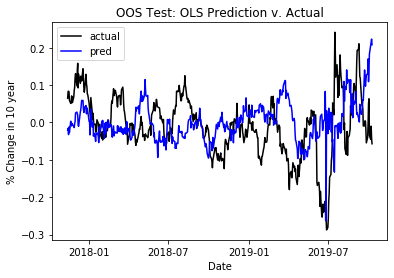

In [73]:
# Create plots of results
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_OLS, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: OLS Prediction v. Actual')
plt.show()

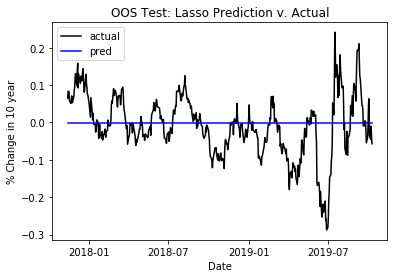

In [74]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_Lasso, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: Lasso Prediction v. Actual')
plt.show()

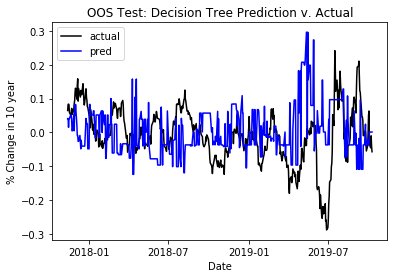

In [75]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_Tree, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: Decision Tree Prediction v. Actual')
plt.show()

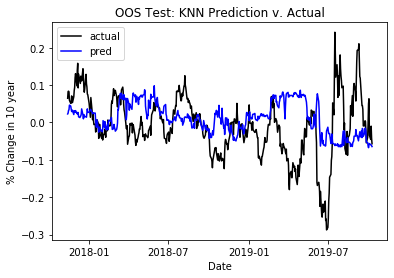

In [76]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_KNN, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: KNN Prediction v. Actual')
plt.show()

As you can see, none of these models are very good. However, this is expected since our variable selection was naive. 

In [77]:
# We can start by narrowing our dataset to only include variables that we believe will be better predictors of rates. 
features = ['Financials', 'Utilities','USGG2YR Index', 'USGG10YR Index', 'GDBR10 Index', 'Dollar Index', 'HG1 Comdty', \
           'LB1 Comdty','CL1 Comdty', 'GC1 Comdty']

In [85]:
X_narrow = select_dataset[features]
X_narrow.head()
X_narrow.shape
Y.shape

(4979,)

In [91]:
# I'll create a function to run through the data splitting and model building process.
def model_train_test(test_len, x, y, dates):
    split = len(x) - test_len
    x_train = x.iloc[:split]
    x_test = x.iloc[split+1:]
    y_train = y.iloc[:split]
    y_test = y.iloc[split+1:]
    date_train = dates.iloc[:split]
    date_test = dates.iloc[split+1:]
    
    # Model forms
    model1 = LinearRegression()
    model2 = linear_model.Lasso() # default alpha = 1
    model3 = DecisionTreeRegressor(max_depth=20)
    model4 = KNeighborsRegressor(n_neighbors=50, weights='distance')
    
    # Fit models
    model1.fit(x_train,y_train)
    model2.fit(x_train,y_train)
    model3.fit(x_train,y_train)
    model4.fit(x_train,y_train)
    
    # Predict Y_test
    pred_1 = model1.predict(x_test)
    pred_2 = model2.predict(x_test)
    pred_3 = model3.predict(x_test)
    pred_4 = model4.predict(x_test)
    
    RMSE_1 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_1))
    RMSE_2 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_2))
    RMSE_3 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_3))
    RMSE_4 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_4))
    return (RMSE_1, RMSE_2, RMSE_3, RMSE_4)

In [94]:
(RMSE_1, RMSE_2, RMSE_3, RMSE_4) = model_train_test(500, X_narrow, Y, date)

In [95]:
print('RMSE for Model 1: %f' % RMSE_1)
print('RMSE for Model 2: %f' % RMSE_2)
print('RMSE for Model 3: %f' % RMSE_3)
print('RMSE for Model 4: %f' % RMSE_4)

RMSE for Model 1: 0.085265
RMSE for Model 2: 0.081953
RMSE for Model 3: 0.131270
RMSE for Model 4: 0.092177


The Lasso regression model remains the best (i.e. I still can't beat a straight line.)